In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scsavailability as scs
    
import statsmodels.api as sm
from scipy import stats

from scsavailability import features as feat, model as md, plotting as pt, score as sc

2020-12-22 11:53:16,701 - NumExpr defaulting to 8 threads.


In [2]:
path = '../raw_data/'

In [3]:
at_raw = pd.read_csv(path+'active_totes_20201123.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-2511.csv')
#fa = pd.read_csv(path + 'scs_tote_matched.csv')
scs_raw = pd.read_csv('../raw_data/SCS alerts Nov.csv')

In [4]:
# HOTFIX - remove odd day
at_raw = at_raw[~at_raw['DAY'].isin([9])]

In [5]:
fa = feat.add_code(scs_raw)
fa, unmapped = feat.add_tote_colour(fa)

Running: Function "load_tote_lookup" (id=2321957843008) was called 1 times


In [6]:
at = feat.pre_process_AT(at_raw)

Running: Function "pre_process_AT" (id=2321957845888) was called 1 times


In [7]:
av = feat.pre_process_av(av)

Running: Function "pre_process_av" (id=2321957846752) was called 1 times


In [8]:
fa = feat.preprocess_faults(fa,remove_same_location_faults = True)

Running: Function "preprocess_faults" (id=2321957845456) was called 1 times
Running: Function "load_module_lookup" (id=2321957844304) was called 1 times
Running: Function "load_ID_lookup" (id=2321957845024) was called 1 times
duplicated location faults removed - max duration kept
HOTFIX: Quadrant only faults, PTT Asset Code update


In [9]:
fa_floor = feat.floor_shift_time_fa(fa, shift=0)

Time shifted by 0Minutes


In [10]:
def run_m(i, fa_floor, av, at):
    mod = [str(i)]
    fa_sel_1 = feat.get_data_faults(fa_floor, modules = mod)
    limit = 250
    most_common = list(((fa_sel_1['Asset Code'].value_counts() > limit)[fa_sel_1['Asset Code'].value_counts() > limit]).index)
    fa_sel = fa_sel_1[fa_sel_1['Asset Code'].isin(most_common)]


    fa_agg = feat.faults_aggregate(fa_sel, fault_agg_level= 'Asset Code', agg_type = 'count')

    av_sel, at_sel = feat.av_at_select(av, at, remove_high_AT = True, availability_select_options = {"Module" : mod})

    av_agg = feat.aggregate_availability(av_sel, agg_level = 'Module')
    at_agg = feat.aggregate_totes(at_sel, agg_level = 'Module')

    df = feat.merge_av_fa_at(av_agg ,at_df=at_agg, fa_df = fa_agg, agg_level = 'None')
    X,y = md.gen_feat_var(df)
    X = X.drop('Module', axis=1)
    # Flip to availability
    y=1-y

    X_train, X_test, y_train, y_test = md.split(X,y)
    Linear_mdl,predictions_LM,Coeff,fit_metrics = md.run_LR_model(X_train, X_test, y_train, y_test)
    cv_R2 = md.cross_validate_r2(Linear_mdl, X, y, n_folds = 5, shuffle = True, random_state = 101)    
    
    model = sm.OLS(y,X)
    results = model.fit()
    keep_features = results.pvalues[results.pvalues < 0.10].index
    model = sm.OLS(y,X[keep_features])
    results = model.fit()
    negs = results.params[results.params < 0]
    df_r = pd.DataFrame(negs, columns=['Coefficient']).reset_index()
    df_r['Module'] = i
    return df_r

In [11]:
a = run_m(1, fa_floor, av, at)

Running: Function "aggregate_availability" (id=2321957846032) was called 1 times

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.518717
2       0.149442
3       0.409224
4       0.275604
5       0.588771
Mean    0.388352
STD     0.159617


In [12]:
full_df = pd.DataFrame(columns=['index','Coefficient', 'Module'])
for i in range(1, 21):
    try:
        a = run_m(i, fa_floor, av, at)
        full_df = full_df.append(a)
    except:
        print(f'Missing Module: {0}'.format(i))

Running: Function "aggregate_availability" (id=2321957846032) was called 2 times

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.518717
2       0.149442
3       0.409224
4       0.275604
5       0.588771
Mean    0.388352
STD     0.159617
Running: Function "aggregate_availability" (id=2321957846032) was called 3 times

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1      -0.143560
2       0.495386
3       0.216410
4      -0.376482
5      -0.212165
Mean   -0.004082
STD     0.316076
Running: Function "aggregate_availability" (id=2321957846032) was called 4 times

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.153958
2       0.472607
3       0.405367
4       0.447988
5       0.295951
Mean    0.355174
STD     0.117405
Running: Function "aggregate_availability" (id=2321957846032) was called 5 times

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.408474
2       0.469008
3       0.402751
4   

C:\Users\chris.hughes\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\chris.hughes\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Running: Function "aggregate_availability" (id=2321957846032) was called 17 times
Missing Module: 0
Running: Function "aggregate_availability" (id=2321957846032) was called 18 times

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.128372
2      -0.022573
3      -0.114705
4      -0.027966
5       0.001265
Mean   -0.007121
STD     0.078328
Running: Function "aggregate_availability" (id=2321957846032) was called 19 times

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.370583
2       0.233528
3       0.130293
4      -0.331004
5       0.181359
Mean    0.116952
STD     0.237870
Running: Function "aggregate_availability" (id=2321957846032) was called 20 times

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.430081
2       0.597878
3       0.586297
4       0.289244
5       0.432485
Mean    0.467197
STD     0.114466
Running: Function "aggregate_availability" (id=2321957846032) was called 21 times

Cross Validation

In [13]:
full_df

,index,Coefficient,Module
0,C1603BCL014,-0.042408,1
0,C1603BCL014,-0.037039,2
0,C1603BCL014,-0.052213,3
0,C2301RDC061,-0.002551,12
1,SCS124,-0.031280,12
0,C2301BCL177,-0.028280,17
0,SCS183,-0.001651,18
0,C2301BCL177,-0.021079,19


### Take last day of faults

In [14]:
fa.groupby('MODULE')['Fault ID'].nunique().reset_index().head()

,MODULE,Fault ID
0,1,40
1,10,42
2,11,66
3,12,66
4,13,55


In [15]:
fa_recent = fa[(fa['timestamp'].dt.day == fa['timestamp'].dt.day.max())]

In [16]:
fa_recent[fa_recent['Asset Code'].isin(full_df['index'])]

,Number,Alert,timestamp,PLC,Desk,Duration,Fault ID,Asset Code,Tote Colour,Loop,Suffix,Pick Station,PLCN,Quadrant,MODULE,Alert Type
159975,430945.0,SCS183: main switch is OFF in automaticmode X:...,2020-11-25 01:49:00,SCSM18,SCS183,1.0,5032,SCS183,Grey,carousel,SCSM18,False,0.0,4.0,18,Fault
169871,430946.0,SCS183: clearance is ON in AUTO/SEMI/MANUAL X:...,2020-11-25 00:44:00,SCSM18,SCS183,2.0,5033,SCS183,Grey,carousel,SCSM18,False,0.0,4.0,18,Fault
169880,430946.0,SCS183: clearance is ON in AUTO/SEMI/MANUAL X:...,2020-11-25 06:21:00,SCSM18,SCS183,4.0,5033,SCS183,Grey,carousel,SCSM18,False,0.0,4.0,18,Fault
82182,130233.0,C16: C1603BCL014 014B54 sensor fault,2020-11-25 01:44:00,C16,P03,5.0,3428,C1603BCL014,Blue,Outside,C1603,False,16.0,0.0,NaN,Fault
119345,431018.0,SCS183: sto: timeout bin from lifter to car X:...,2020-11-25 13:49:00,SCSM18,SCS183,6.0,5105,SCS183,Grey,carousel,SCSM18,False,0.0,4.0,18,Fault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162475,420484.0,SCS124: load device: slit sensor B1 X:10 Y:3 ...,2020-11-25 03:26:00,SCSM12,SCS124,499.0,5099,SCS124,Grey,carousel,SCSM12,False,0.0,3.0,12,Fault
119327,431018.0,SCS183: sto: timeout bin from lifter to car X:...,2020-11-25 21:39:00,SCSM18,SCS183,509.0,5105,SCS183,Grey,carousel,SCSM18,False,0.0,4.0,18,Fault
131100,188671.0,C23: C2301BCL177 177QM11 motor circuit breaker...,2020-11-25 13:37:00,C23,P01,685.0,3430,C2301BCL177,Blue,Outside,C2301,False,23.0,0.0,NaN,Fault
82229,188662.0,C23: C2301BCL177 177B51 sensor fault,2020-11-25 02:54:00,C23,P01,878.0,3428,C2301BCL177,Blue,Outside,C2301,False,23.0,0.0,NaN,Fault


In [17]:
fa_recent[fa_recent['Asset Code'].isin(full_df['index'])]['Fault ID'].value_counts()

3428    31
5033    28
5105    18
5032     2
5099     1
3430     1
Name: Fault ID, dtype: int64

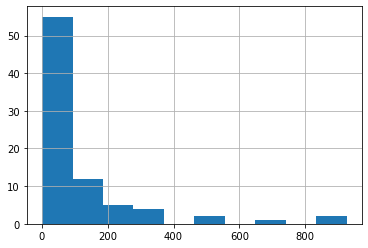

In [18]:
fa_recent[fa_recent['Asset Code'].isin(full_df['index'])]['Duration'].hist()